In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import itertools
from operator import itemgetter
import copy
import numpy as np

# intro: load example graph

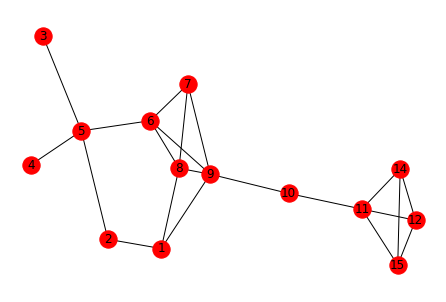

In [4]:
g = nx.Graph([])
g.add_edges_from([(1,2),(1,8),(1,9),
                  (5,2),
                  (5,3),
                  (5,4),
                  (5,6),
                  (6,7),
                  (6,8),
                  (6,9),
                  (7,8),
                  (7,9),
                  (8,9),
                  (9,10),
                  (10,11),
                  (11,14),
                  (11,15),
                  (11,12),
                  (14,15),
                  (15,12),
                  (12,14)
                 ])
nx.draw(g,with_labels=True)
plt.show()

# naive algo

In [214]:
def elbow(sorted_scores):
    sorted_scores = [np.array(i) for i in sorted_scores]
    #traduit de R, du code de l'article original
#     if len(sorted_scores)<3:
#         elbow_point=1
#     else:
     # first point
    first_point = sorted_scores[0]
     # last point
    last_point =sorted_scores[-1]

    # compute distance between each point of "sorted_scores" and the "first-last" line
    distances = []

    for index,point in enumerate(sorted_scores):
        point= np.array(point)

        #calculate distance between the point and the line drawn between first point and last point
        d=np.cross(last_point-first_point,point-first_point)/np.linalg.norm(last_point-first_point)
        distances.append(abs(d))

    #print(distances)
    if np.max(distances)>0:
        x_elbow=sorted_scores[np.argmax(distances)]
    else :
        x_elbow=sorted_scores[0]

#     print(distances)
#     print(elbow)
    return x_elbow


In [215]:
def get_density(g):
    e = g.number_of_edges()
    v = g.number_of_nodes()

    if v !=0:
        density = abs(e)/(abs(v)*(abs(v)-1))
        return density
    else : 
        return None

def dens_method(k_core_decomp):
    D=[]
    for i in range(max(k_core_decomp.values())):
        nodes_indexes = [k for k, v in k_core_decomp.items() if v >i]
        g_small = g.subgraph(nodes_indexes)
        D.append(get_density(g_small))
    return elbow([i for i in enumerate(D)])[0]+1 # +1 as we started counting at zero

def get_keywords(g):
    k_core_decomp = nx.core_number(g) # replace by custom made function
    k_core_value_of_keywords = dens_method(k_core_decomp)
    keywords = [k for k, v in k_core_decomp.items() if v >= k_core_value_of_keywords]
    return keywords

# def get_keywords_cython(g):
#     k_core_decomp = nx.core_number(g) # replace by custom made function
#     k_core_value_of_keywords = dens_method(k_core_decomp)
#     keywords = [k for k, v in k_core_decomp.items() if v >= k_core_value_of_keywords]
#     return keywords

# Now in Cython

In [170]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [207]:
%%cython
import numpy as np
from libc.math cimport sqrt
import networkx as nx
from cpython cimport array
from array import array as pyarray
from libc.string cimport memcpy

def cylistappend(lst, x):      
    result = lst[:]                                  
    result.append(x)                            
    return result


cdef float cross_prod_vect(double[:] first_point, double[:] last_point,  double[:] point):
    cdef float Ax = (last_point[0] - first_point[0])
    cdef float Ay = (last_point[1]-first_point[1])
    cdef float Bx = (point[0]-first_point[0])
    cdef float By = (point[1]-first_point[1])
    cdef float result= Ax*By-Ay*Bx
    cdef float norm = sqrt(Ax*Ax+Ay*Ay)
#     print(result)
    return result/norm
    
#     return v1

cdef float cross_prod(float Ax, float Ay, float Bx, float By):
    
    cdef float result= Ax*By-Ay*Bx
    cdef float norm = sqrt(Ax*Ax+Ay*Ay)
    return result/norm

def c_elbow(double[:, :] sorted_scores):

    cdef int elbow_point
    
#     if (len_array<3):
#         elbow_point=1
#     else:
     # first point
    DTYPE = np.intc

    first_point = sorted_scores[0]

     # last point
    last_point = sorted_scores[-1]

    # compute distance between each point of "sorted_scores" and the "first-last" line
    distances = []#pyarray('f', [])

    cdef int N = sorted_scores.shape[0]
    
    #from https://cython.readthedocs.io/en/latest/src/tutorial/cython_tutorial.html
    cdef int n,i,len_p
    cdef float p[1000]
    cdef double[:] Y = np.zeros(N)

    for i in range(N):
        point = sorted_scores[i]
        d = cross_prod_vect(first_point,last_point,point)
        Y[i]=abs(d)
        

    if np.max(Y)>0:
        x_elbow=sorted_scores[np.argmax(Y)]
    else :
        x_elbow=sorted_scores[0]

    return x_elbow

    
def c_get_density(g):
    e = g.number_of_edges()
    v = g.number_of_nodes()

    if v !=0:
        density = abs(e)/(abs(v)*(abs(v)-1))
        return density
    else : 
        return None




In [216]:
def c_dens_method(k_core_decomp):
    D=[]
    for i in range(max(k_core_decomp.values())):
        nodes_indexes = [k for k, v in k_core_decomp.items() if v >i]
        g_small = g.subgraph(nodes_indexes)
        D.append(c_get_density(g_small))
#     print(D)
    final_array = np.array([i for i in enumerate(D)])#.astype(np.intc)
    
    return c_elbow(final_array)[0]+1 # +1 as we started counting at zero

def c_get_keywords(g):
    k_core_decomp = nx.core_number(g) # replace by custom made function
    k_core_value_of_keywords = c_dens_method(k_core_decomp)
    keywords = [k for k, v in k_core_decomp.items() if v >= k_core_value_of_keywords]
    return keywords



In [217]:
get_keywords(g)

[1, 2, 8, 9, 5, 6, 7, 10, 11, 14, 15, 12]

In [220]:
c_get_keywords(g)

[1, 2, 8, 9, 5, 6, 7, 10, 11, 14, 15, 12]

## time

In [224]:
G = nx.duplication_divergence_graph(3000,0.7)

In [225]:
%timeit get_keywords(G)

KeyboardInterrupt: 

In [ ]:
%timeit c_get_keywords(G)

## memory usage

In [13]:
# pip install memory_profiler

In [14]:
%load_ext memory_profiler

In [16]:
%memit get_keywords(g)

peak memory: 132.08 MiB, increment: 0.01 MiB


In [17]:
%memit c_get_keywords(g)

peak memory: 132.20 MiB, increment: 0.01 MiB


In [18]:
import cProfile
import re


In [19]:
cProfile.run('re.compile("foo|bar")')

         214 function calls (207 primitive calls) in 0.000 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <string>:1(<module>)
        2    0.000    0.000    0.000    0.000 enum.py:284(__call__)
        2    0.000    0.000    0.000    0.000 enum.py:526(__new__)
        1    0.000    0.000    0.000    0.000 enum.py:836(__and__)
        1    0.000    0.000    0.000    0.000 re.py:232(compile)
        1    0.000    0.000    0.000    0.000 re.py:271(_compile)
        1    0.000    0.000    0.000    0.000 sre_compile.py:249(_compile_charset)
        1    0.000    0.000    0.000    0.000 sre_compile.py:276(_optimize_charset)
        2    0.000    0.000    0.000    0.000 sre_compile.py:453(_get_iscased)
        1    0.000    0.000    0.000    0.000 sre_compile.py:461(_get_literal_prefix)
        1    0.000    0.000    0.000    0.000 sre_compile.py:492(_get_charset_prefix)
        1   